# The map equation
http://www.mapequation.org/assets/publications/EurPhysJ2010Rosvall.pdf


In [1]:
%matplotlib inline

In [2]:
import math
import random
import time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import d3shims

In [3]:
G = nx.Graph()
G.add_edges_from([
    (1, 2), (1, 3), (2, 3), (4, 2), (5, 2), (5, 6), (2, 6), 
    (3, 6), (3, 7), (7, 8), (7, 9), (7, 10), (9, 10), (9, 11), 
    (8, 9), (8, 12), (9, 12), (11, 12), (13, 12), (13, 11), 
    (13, 10), (13, 14), (14, 15), (14, 16), (15, 16), (15, 17), 
    (16, 17), (16, 18), (18, 19), (19, 20), (20, 18), (18, 21), 
    (21, 22), (22, 20), (19, 22), (23, 22), (24, 22), (25, 22), 
    (25, 24), (25, 21), (25, 10),
])

optimal_modules = [
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12, 13],
    [14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23, 24, 25],
]

In [4]:
d3shims.nx_force(G, size=(300, 300))

For a module partition $M$ of $n$ nodes $α = 1, 2,...,n$ into $m$ modules $i = 1, 2,...,m$, we define this lower bound on code length to be $L(M)$. To calculate $L$ for an arbitrary partition, we first invoke [Shannon's source coding theorem](https://en.wikipedia.org/wiki/Shannon%27s_source_coding_theorem), which implies that when you use $n$ codewords to describe the $n$ states of a random variable $X$ that occur with frequencies $p_i$, the average length of a codeword can be no less than the entropy of the random variable $X$ itself: $H(X) = - \sum p_i log_2(p_i)$ (we measure code lengths in bits and take the logarithm in base 2).

In [5]:
freqs = [100, 10]
n = len(freqs)
pi = [f / sum(freqs) for f in freqs]

In [6]:
H = -sum(p * math.log2(p) for p in pi)
print('Theoretical minimum to encode each state: {:0.3f} bits'.format(H))

Theoretical minimum to encode each state: 0.439 bits


---

### Sidebar: Random Walker probability of visiting any given node in an undirected graph

Equal to the number of neighbors the node has, divided by twice (one per link end) the total edge weight of the graph: "relative weight", $w_\alpha$.

In [7]:
nodes = G.nodes()
edges = G.edges()

neighbors = [len(G.neighbors(n)) for n in nodes]
counts = {k: 0 for k in nodes}
loc = random.choice(list(counts.keys()))

iters = int(5e5)
for step in range(iters):
    loc = random.choice(G.neighbors(loc))
    counts[loc] += 1

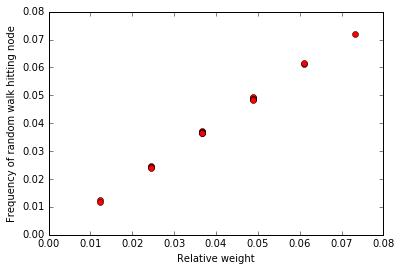

In [8]:
f, ax = plt.subplots()
ax.plot([n/len(edges)/2 for n in neighbors], [counts[n]/iters for n in nodes], 'ro')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel('Relative weight')
ax.set_ylabel('Frequency of random walk hitting node')
plt.show()

---

## The equation
  
$$L(\mathsf{M}) = q_\curvearrowright H(\mathcal{Q}) + \sum_{i = 1}^{m}p^i_\circlearrowright H(\mathcal{P}^i)$$

* $H(\mathcal{Q})$ - frequency weighted average length of codewords in the index codebook
* $H(\mathcal{P}^i)$ - frequency weighted average length of codewords in the module cookbook $i$
* $q_{i\curvearrowright}$ - probability to exit module $i$
  * $q_{\curvearrowright} = \sum_i q_{i\curvearrowright}$  - probability to exit any module and use the module cookbook
* $p_\alpha$ - probability to visit node $\alpha$
  * $p^i_\circlearrowright = \sum_{\alpha \in i} p_\alpha + q_{i \curvearrowright}$ - probability to use the module cookbook $i$: how often the random walk is in the module plus the frequency that the module is exited

For convienence, let $f(x) = x \log x$

$$H(\mathcal{Q}) = - \sum^m_{i=1}{f\left(\frac{q_{i \curvearrowright}}{\sum^m_{j=1}{q_{j \curvearrowright}}}\right)}$$

$$H(\mathcal{P}^i) = 
 - f\left(\frac{q_{i \curvearrowright}}{q_{i \curvearrowright} + \sum_{\beta \in i}{p_\beta}}\right) 
 - \sum_{\alpha \in i}{f\left(\frac{p_\alpha}{q_{i \curvearrowright} + \sum_{\beta \in i}{p_\beta}}\right)}$$

After combining and simplifying

$$L(\mathsf{M}) = 
 f\left(\sum^{m}_{i=1}{q_{i \curvearrowright}}\right)
 - 2 \sum^{m}_{i=1}{f\left(q_{i \curvearrowright}\right)}
 - \sum^{n}_{\alpha=1}{f\left(p_\alpha\right)}
 + \sum^{m}_{i=1}{f\left(q_{i \curvearrowright} + \sum_{\alpha \in i}{p_\alpha}\right)}$$


In an undirected network:

* $w_\alpha$ : the relative weight of node $\alpha$
* $w_i = \sum_{\alpha \in i}w_\alpha$ : the relative weight of module $i$
* $w_{i \curvearrowright}$ : the relative weight of links exiting module $i$
* $w_\curvearrowright = \sum^m_{i=1}w_{i \curvearrowright}$ : the relative weight of links between all modules

$$
L(\mathsf{M}) = 
 f\left(w_{ \curvearrowright}\right)
 - 2 \sum^{m}_{i=1}{f\left(w_{i \curvearrowright}\right)}
 - \sum^{n}_{\alpha=1}{f\left(w_\alpha\right)}
 + \sum^{m}_{i=1}{f\left(w_{i \curvearrowright} + w_i\right)}
$$

In [9]:
def total_edge_weight(G):
    return (1 if G.is_directed() else 2) * sum(edge[2].get('weight', 1) for edge in G.edges_iter(data=True))
        
def node_weight(G, n):
    return sum(edge[2].get('weight', 1) for edge in G.edges_iter(n, data=True))

def relative_weight(G, n):
    if 'rw' not in G.node[n]:
        G.node[n]['rw'] = node_weight(G, n) / total_edge_weight(G)
    return G.node[n]['rw']

In [10]:
relative_weight(G, 4)

0.012195121951219513

In [11]:
G.node[4]

{'rw': 0.012195121951219513}

In [12]:
modules = {n: n for n in G.nodes_iter()}

* graph total weight
* node relative weight
* module relative weight
* node to module map
* module to node map


In [13]:
from collections import defaultdict 
import copy

def nlogn(n):
    return n * np.log2(n)

class MapEqnManager:
    def __init__(self, graph):
        self.G = graph
        if self.G.is_directed():
            raise ValueError('directed graphs not supported yet')
        
        self._init_weights()
        self._init_modules()

    def _init_weights(self):
        self.Gtw = total_edge_weight(self.G)
        self.nrw = {}
        for n in self.G.nodes_iter():
            self.nrw[n] = node_weight(G, n) / self.Gtw
        self.term3 = -sum(nlogn(rw) for rw in self.nrw.values())

    def _init_modules(self):
        self.nm = {}
        self.mn = defaultdict(set)
        
        # each node is it's own module at the start
        for n in self.G.nodes_iter():    
            self.nm[n] = n
            self.mn[n].add(n)
        
    def module_weight(self, m):
        return sum(self.nrw[n] for n in self.mn[m])
    
    def module_exit_weight(self, m):
        return sum(self.G.node[n].get('weight', 1) / self.Gtw 
                for n, neighbor 
                in self.G.edges_iter(self.mn[m]) 
                if neighbor not in self.mn[m])
    
    def total_exit_weight(self):
        return sum(self.module_exit_weight(m) for m, nodes in self.mn.items() if nodes)
        
    def _verify_module_map_consistency(self):
        """
        Checks synchronization between node->module and module->nodes mappings
        """
        nodes = set(self.nm)
        mn_temp = copy.deepcopy(self.mn)
        while nodes:
            n = nodes.pop()
            m = self.nm[n]
            try:
                mn_temp[m].remove(n)
            except KeyError:
                raise AssertionError('node {} not in expected module {}'.format(n, m))
        
        for m, m_leftovers in mn_temp.items():
            assert not m_leftovers, 'extra node in module map! (node(s) {} in module {})'.format(m_leftovers, m)
        
    def move_node_to_module(self, n, m):
        self.mn[self.nm[n]].remove(n)
        
        self.nm[n] = m
        self.mn[m].add(n)
    
    def single_module(self, the_one=1):
        for n in self.nm:
            self.nm[n] = the_one
        self.mn = defaultdict(set, {the_one: set(self.nm)})
    
    def code_length(self):
        mod_weights = {m: self.module_weight(m) for m, nodes in self.mn.items() if nodes}
        if len(mod_weights) == 1:
            # single module, the other terms are useless/invalid
            return self.term3
        
        mod_exit_weights = {m: self.module_exit_weight(m) for m in mod_weights}
        total_exit_weight = sum(mod_exit_weights.values())
        return (nlogn(total_exit_weight) 
                - 2 * sum(nlogn(ew) for ew in mod_exit_weights.values()) 
                + self.term3 
                + sum(nlogn(mod_weights[m] + mod_exit_weights[m]) for m in mod_weights))
    
    def d3(self, *args, **kwargs):
        # copy modules to "group" attribute on nodes
        for n, m in self.nm.items():
            self.G.node[n]['group'] = m
        return d3shims.nx_force(self.G, *args, **kwargs)
    
    def best_neighbor_merge(self, n):
        ...

In [14]:
mem = MapEqnManager(G)
mem._verify_module_map_consistency()

In [15]:
mem.code_length()

6.5433062000996918

In [16]:
mem.single_module()
mem._verify_module_map_consistency()

In [17]:
mem.code_length()

4.54330620009969

In [18]:
for module, nodes in enumerate(optimal_modules):
    for node in nodes:
        mem.move_node_to_module(node, module)

In [19]:
mem.code_length()

3.2670285810463575

In [20]:
mem.d3((300, 300))

## Minimizing the Map Equation

### "Core algorithm"
1. Randomly order the nodes
1. For each node, move to the neighboring module that provides the greatest decrease. If nothing provides a decrease, keep as-is.
1. Repeat the above steps until no changes result in a decrease of the map equation.
1. Transform the modules found above into nodes and repeat the process.

In [21]:
mem = MapEqnManager(G)
mem.code_length()

6.5433062000996918

In [22]:
def get_nodes_and_shuffle(G):
    nodes = list(G.nodes_iter())
    random.shuffle(nodes)
    return nodes

nodes = get_nodes_and_shuffle(mem.G)
print(nodes)

[8, 18, 10, 2, 24, 17, 5, 20, 12, 1, 9, 21, 16, 6, 7, 4, 22, 25, 3, 11, 23, 15, 14, 13, 19]


In [23]:
def find_greatest_neighbor_decrease(mG, n):
    node_module = mG.nm[n] # module of focal node
    neighbors = mG.G.neighbors(n)
    scores = {None: mG.code_length()}
    
    for neighbor in neighbors:
        original_module = mG.nm[neighbor]
        mG.move_node_to_module(neighbor, node_module)
        scores[neighbor] = mG.code_length()
        mG.move_node_to_module(neighbor, original_module)
        
    return min(scores.keys(), key=lambda k: scores[k])

print(mem.G.neighbors(1))
print(find_greatest_neighbor_decrease(mem, 1))

[2, 3]
3


In [24]:
mem.d3((300, 300))

In [25]:
def core_iteration(mG):
    nodes = get_nodes_and_shuffle(mG.G)
    
    start = mG.nm.copy()
    #changed = False
    for n in nodes:
        best = find_greatest_neighbor_decrease(mG, n)
        if best is None:
            continue
        mG.move_node_to_module(best, mG.nm[n])
        # oscillations might be thwarting "any change" meaning "a net change"
        # need to check, for now just check en-masse at start/end
        #changed = True 

    return set(start.items()) != set(mG.nm.items())

In [26]:
core_iteration(mem)

True

In [27]:
mem.d3((300, 300))

In [28]:
mem = MapEqnManager(G)
start = time.time()
while True:
    changes = core_iteration(mem)

    if not changes:
        break
    elif time.time() - start > 5:
        raise Exception('timeout')

print(mem.code_length())
mem.d3((300, 300))

3.52818480528


In [29]:
def get_modules_and_shuffle(mG):
    modules = [module for module, nodes in mG.mn.items() if nodes]
    random.shuffle(modules)
    return modules

modules = get_modules_and_shuffle(mem)
print(modules)

[5, 19, 25, 13, 14, 8]


In [30]:
def move_nodes_to_module(mG, nodes, module):
    for node in set(nodes):
        mG.move_node_to_module(node, module)

def find_greatest_module_neighbor_decrease(mG, module):
    module_neighbors = set()
    for node in mG.mn[module]:
        for neighbor in mG.G.neighbors(node):
            module_neighbors.add(mG.nm[neighbor])
    module_neighbors.discard(module)
            
    scores = {None: mG.code_length()}
    
    for mneighbor in module_neighbors:
        nodes = set(mG.mn[mneighbor]) # copy
        move_nodes_to_module(mG, nodes, module)
        #for node in nodes:
        #    mG.move_node_to_module(node, module)
        scores[mneighbor] = mG.code_length()
        move_nodes_to_module(mG, nodes, mneighbor)
        #for node in nodes:
        #    mG.move_node_to_module(node, mneighbor)
        
    return min(scores.keys(), key=lambda k: scores[k])

find_greatest_module_neighbor_decrease(mem, 19)

25

In [31]:
def hierarchical_iteration(mG):
    modules = get_modules_and_shuffle(mG)
    
    start = set(mG.nm.items())
    for m in modules:
        mbest = find_greatest_module_neighbor_decrease(mG, m)
        if mbest is None:
            continue
        move_nodes_to_module(mG, mG.mn[mbest], m)

    return start != set(mG.nm.items())

In [32]:
hierarchical_iteration(mem)

True

In [33]:
mem.d3((300, 300))